In [41]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from definitions import ROOT_DIR


In [42]:
results_dir = Path(ROOT_DIR, 'results', 'final_analytical')
# results_dir = Path(ROOT_DIR, 'results', 'prisoners_dilemma')
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_dm')
vi_results_dir = Path(ROOT_DIR, 'results', 'vi')
pomdp_files_dir = Path(ROOT_DIR, 'grl', 'environment', 'pomdp_files')

args_to_keep = ['spec', 'n_mem_states', 'seed']
split_by = [arg for arg in args_to_keep if arg != 'seed']

# this option allows us to compare to either the optimal belief state soln
# or optimal state soln. ('belief' | 'state')
compare_to = 'belief'

spec_plot_order = [
    'example_7', 'tmaze_5_two_thirds_up', 'tiger-alt-start', 'paint.95', 'cheese.95', 'network',
    'shuttle.95', '4x3.95', 'hallway'
]

# game_name = 'prisoners_dilemma'
# # leader_policies = ['all_d', 'extort', 'tit_for_tat', 'treasure_hunt', 'sugar', 'all_c', 'grudger2', 'alternator', 'majority3']

# leader_policies = ['all_d', 'extort', 'tit_for_tat', 'treasure_hunt', 'sugar', 'grudger2', 'alternator', 'majority3']
# leader_policy_labels = {
#     'all_d': 'all d', 
#     'extort': 'extort', 
#     'tit_for_tat': 'tit for\ntat',
#     'treasure_hunt': 'treasure\nhunt',
#     'sugar':'sugar', 
#     'all_c': 'all c', 
#     'grudger2': 'grudger 2', 
#     'alternator':'alternator', 
#     'majority3':'majority 3'
# }

# spec_plot_order = []
# prisoners_spec_map = {}
# for leader in leader_policies:
#     spec_id = f'{game_name}_{leader}'
#     prisoners_spec_map[spec_id] = leader_policy_labels[leader]
#     spec_plot_order.append(spec_id)

spec_to_belief_state = {'tmaze_5_two_thirds_up': 'tmaze5'}



In [43]:
compare_to_dict = {}

for spec in spec_plot_order:
    if compare_to == 'belief':

        for fname in pomdp_files_dir.iterdir():
            if 'pomdp-solver-results' in fname.stem:
                if (fname.stem ==
                        f"{spec_to_belief_state.get(spec, spec)}-pomdp-solver-results"
                    ):
                    belief_info = load_info(fname)
                    coeffs = belief_info['coeffs']
                    max_start_vals = coeffs[belief_info['max_start_idx']]
                    compare_to_dict[spec] = np.dot(max_start_vals, belief_info['p0'])
                    break
                    # print(f"loaded results for {hparams.spec} from {fname}")
        else:
            for vi_path in vi_results_dir.iterdir():
                for spec in spec_plot_order:
                    if spec_to_belief_state.get(spec, spec) in vi_path.name:
                        vi_info = load_info(vi_path)
                        max_start_vals = vi_info['optimal_vs']
                        compare_to_dict[spec] = np.dot(max_start_vals, vi_info['p0'])
                        
    elif compare_to == 'state':
        for vi_path in vi_results_dir.iterdir():
            if spec_to_belief_state.get(spec, spec) in vi_path.name:
                vi_info = load_info(vi_path)
                max_start_vals = vi_info['optimal_vs']
                compare_to_dict[spec] = np.dot(max_start_vals, vi_info['p0'])
                
#                 compare_to_list.append(spec_compare_indv)


In [44]:
compare_to_dict


{'example_7': 1.2499999999999998,
 'tmaze_5_two_thirds_up': 1.9131876000000005,
 'tiger-alt-start': 3.7701893248807115,
 'paint.95': 3.293597084371071,
 'cheese.95': 3.486206824190127,
 'network': 293.18528731501624,
 'shuttle.95': 32.88972468934434,
 '4x3.95': 1.8834177056359047,
 'hallway': 1.5357724175997975}

In [53]:
all_results = []

for results_path in results_dir.iterdir():
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue

    info = load_info(results_path)

    args = info['args']
#     if args['spec'] not in prisoners_spec_map.keys():
#         continue

    # agent = info['agent']
    init_policy_info = info['logs']['initial_policy_stats']
    init_improvement_info = info['logs']['greedy_initial_improvement_stats']
    final_mem_info = info['logs']['greedy_final_mem_stats']

    def get_perf(info: dict):
        return (info['state_vals_v'] * info['p0']).sum()
    single_res = {k: args[k] for k in args_to_keep}

    final_mem_perf = get_perf(final_mem_info)
    compare_to_perf = compare_to_dict[args['spec']]
    init_policy_perf = get_perf(init_policy_info)
    init_improvement_perf = get_perf(init_improvement_info)
#     if (final_mem_perf > compare_to_perf):
#         if np.isclose(final_mem_perf, compare_to_perf):
#             final_mem_perf = compare_to_perf
#         else:
#             raise Exception(f"{args['spec']}, compare_to_perf: {compare_to_perf:.3f}, final_mem_perf: {final_mem_perf:.3f}")
    
    if init_policy_perf > init_improvement_perf:
        init_policy_perf = init_improvement_perf
    
    single_res.update({
        'init_policy_perf': init_policy_perf,
        'init_improvement_perf': init_improvement_perf,
        'final_mem_perf': final_mem_perf,
        'compare_to_perf': compare_to_perf,
        # 'init_policy': info['logs']['initial_policy'],
        # 'init_improvement_policy': info['logs']['initial_improvement_policy'],
        # 'final_mem': np.array(agent.memory),
        # 'final_policy': np.array(agent.policy)
    })
    all_results.append(single_res)


all_res_df = pd.DataFrame(all_results)

In [46]:
all_res_groups = all_res_df.groupby(split_by, as_index=False)
all_res_means = all_res_groups.mean()
del all_res_means['seed']
all_res_means.to_csv(Path(ROOT_DIR, 'results', 'all_pomdps_means.csv'))

In [54]:
cols_to_normalize = ['init_improvement_perf', 'final_mem_perf']
# merged_df = all_res_df.merge(compare_to_df, on='spec')
merged_df = all_res_df

# for col_name in cols_to_normalize:

normalized_df = merged_df.copy()
normalized_df['init_improvement_perf'] = (normalized_df['init_improvement_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_to_perf'] - merged_df['init_policy_perf'])
normalized_df['final_mem_perf'] = (normalized_df['final_mem_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_to_perf'] - merged_df['init_policy_perf'])
del normalized_df['init_policy_perf']
del normalized_df['compare_to_perf']

In [55]:
normalized_df

,spec,n_mem_states,seed,init_improvement_perf,final_mem_perf
0,paint.95,2,2026,0.566111,0.571591
1,example_7,8,2020,0.578541,0.999985
2,network,8,2031,0.334492,0.390076
3,cheese.95,4,2021,0.055589,1.026912
4,hallway,2,2041,0.140929,0.137362
...,...,...,...,...,...
784,4x3.95,8,2045,0.076624,0.780435
785,tmaze_5_two_thirds_up,4,2027,0.533192,0.979696
786,network,2,2035,0.189564,0.257254
787,network,2,2033,0.228446,0.292888


In [48]:
# normalized_df[normalized_df['spec'] == 'prisoners_dilemma_all_c']
seeds = normalized_df[normalized_df['spec'] == 'tmaze_5_two_thirds_up']['seed'].unique()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (8,).

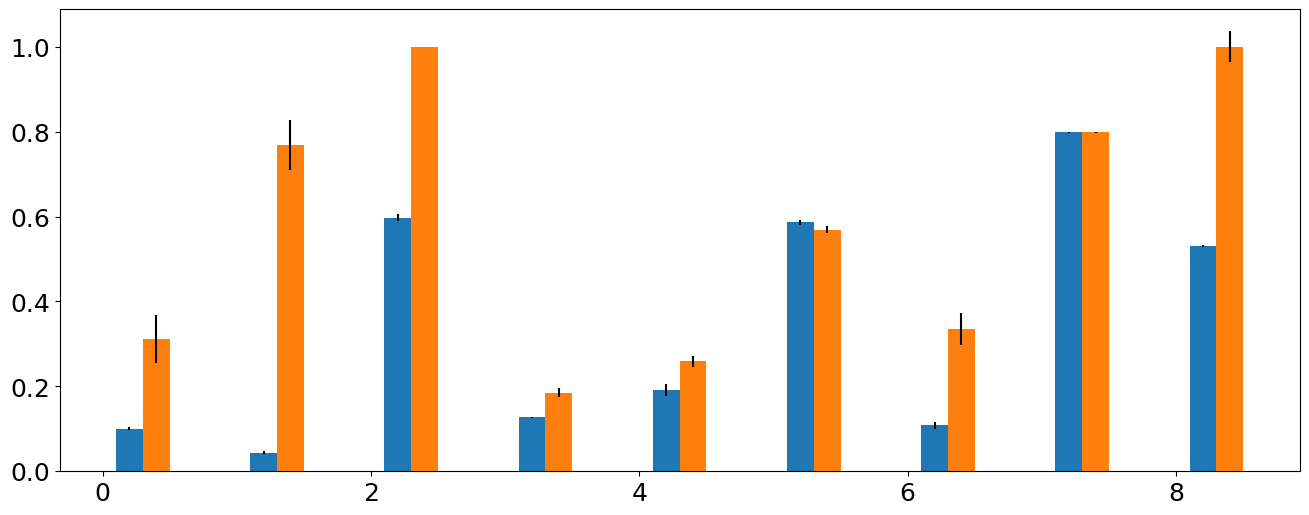

In [49]:
def maybe_spec_map(id: str):
    spec_map = {
        '4x3.95': '4x3',
        'cheese.95': 'cheese',
        'paint.95': 'paint',
        'shuttle.95': 'shuttle',
        'example_7': 'ex. 7',
        'tmaze_5_two_thirds_up': 'tmaze',
        'tiger-alt-start': 'tiger'
    }
    
#     spec_map |= prisoners_spec_map
    
    if id not in spec_map:
        return id
    return spec_map[id]

groups = normalized_df.groupby(split_by, as_index=False)
means = groups.mean()
means['init_improvement_perf'].clip(lower=0, upper=1, inplace=True)
means['final_mem_perf'].clip(lower=0, upper=1, inplace=True)

std_errs = groups.std()
std_errs['init_improvement_perf'] /= np.sqrt(len(seeds))
std_errs['final_mem_perf'] /= np.sqrt(len(seeds))

num_n_mem = list(sorted(normalized_df['n_mem_states'].unique()))

group_width = 1
bar_width = group_width / (len(num_n_mem) + 2)
fig, ax = plt.subplots(figsize=(16, 6))

specs = means[means['n_mem_states'] == num_n_mem[0]]['spec']
# spec_order_mapping = [spec_plot_order.index(s) for s in specs]
spec_order_mapping = np.arange(len(specs), dtype=int)

xlabels = [maybe_spec_map(l) for l in specs]
x = np.arange(len(specs))

init_improvement_perf_mean = np.array(means[means['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])
init_improvement_perf_std = np.array(std_errs[std_errs['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])

ax.bar(x + (0 + 1) * bar_width,
       init_improvement_perf_mean,
       bar_width,
       yerr=init_improvement_perf_std,
       label='Memoryless')

for i, n_mem_states in enumerate(num_n_mem):
    curr_mem_mean = np.array(means[means['n_mem_states'] == n_mem_states]['final_mem_perf'])
    curr_mem_std = np.array(std_errs[std_errs['n_mem_states'] == n_mem_states]['final_mem_perf'])
    ax.bar(x + (i + 2) * bar_width,
           curr_mem_mean,
           bar_width,
           yerr=curr_mem_std,
           label=f"{int(np.log2(n_mem_states))} Memory Bits")

ax.set_ylim([0, 1.05])
ax.set_ylabel(f'Relative Performance\n (w.r.t. optimal {compare_to} & initial policy)')
ax.set_xticks(x + group_width / 2)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(1., 1.), framealpha=0.95)
ax.set_title("Performance of Memory Iteration in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}.pdf"
fig.savefig(fig_path, bbox_inches='tight')

In [52]:
curr_mem_std.shape, curr_mem_mean.shape

((8,), (8,))